In [1]:
import random
import evidently
import pandas as pd
from pathlib import Path
from sklearn import datasets
import matplotlib.pyplot as plt


from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from evidently.pipeline.column_mapping import ColumnMapping




In [2]:

def generate_datasets() -> None:
    """
    Create two random samples if there are sufficient rows in the dataset.
    """
    # Define the data directory and file paths
    data_dir = Path('../../data')
    fraud_test_file = data_dir / 'fraud_test.csv'
    reference_sample_file = data_dir / 'reference_sample.csv'
    production_sample_file = data_dir / 'production_sample.csv'

    # Check if the input file exists
    if not fraud_test_file.exists():
        print(f"File not found: {fraud_test_file}")
        return

    # Load the dataset
    df = pd.read_csv(fraud_test_file)

    # Determine the number of rows
    num_rows: int = len(df)
    print(f"Number of rows in the dataset: {num_rows}")

    # Stop if there are less than 2000 rows
    if num_rows < 2000:
        print("Not enough rows in the dataset. Exiting.")
        return

    # Take 1_000 random rows for the reference sample
    reference_indices = random.sample(range(num_rows), 1000)
    reference_sample = df.iloc[reference_indices]

    # Take another 1_000 random rows for the production sample (different from the first set)
    remaining_indices = list(set(range(num_rows)) - set(reference_indices))
    production_indices = random.sample(remaining_indices, 1000)
    production_sample = df.iloc[production_indices]

    # Save the samples to their respective files
    reference_sample.to_csv(reference_sample_file, index=False)
    production_sample.to_csv(production_sample_file, index=False)

    print(f"Saved reference sample to: {reference_sample_file}")
    print(f"Saved production sample to: {production_sample_file}")

generate_datasets()


Number of rows in the dataset: 555719
Saved reference sample to: ..\..\data\reference_sample.csv
Saved production sample to: ..\..\data\production_sample.csv


In [3]:
# Replace the path with your actual path
reference = pd.read_csv("../../data/reference_sample.csv")
production = pd.read_csv("../../data/production_sample.csv")

In [4]:
reference.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,150168,2020-08-12 10:55:58,4561892980175,fraud_Sporer Inc,gas_transport,72.42,Jacqueline,Allen,F,166 Lisa Fords,...,39.5960,-86.1309,78968,Financial adviser,1968-02-10,a6b5abc3989c70fa5e24022eaf88d109,1376304958,40.038081,-86.620118,0
1,107827,2020-07-28 14:04:25,2288813824604479,fraud_Thiel PLC,misc_pos,191.16,Barbara,Norman,F,6278 Stephanie Unions,...,40.8265,-73.9383,1577385,Herbalist,1981-08-29,56b756f97b42e7548f65aa33abc195ae,1375020265,40.700557,-74.869606,0
2,394078,2020-11-23 00:57:32,6534628260579800,fraud_Wiegand-Lowe,grocery_net,25.51,Christine,Harris,F,29606 Martinez Views Suite 653,...,44.3346,-73.0980,4542,Claims inspector/assessor,1998-03-19,d07ef9c8eab28bbb5168b30f2fc395c2,1385168252,44.723105,-73.002268,0
3,411869,2020-11-30 10:39:48,377113842678100,fraud_Heller-Langosh,gas_transport,59.78,Billy,Gallagher,M,673 Delgado Burg,...,39.4055,-75.3209,804,Insurance risk surveyor,1965-03-25,5222bbe602a7aa82df4f5c0bf9600e39,1385807988,39.530649,-75.553273,0
4,207642,2020-09-01 19:33:30,213198837352314,fraud_Rau-Grant,kids_pets,45.42,John,Vega,M,4483 Sharp Ferry Apt. 468,...,38.0649,-99.2374,365,Equality and diversity officer,1991-02-03,eb8afd9e92c2cf2eb0b50449fbe6f3b8,1378064010,38.331540,-98.709155,0


In [5]:

# Remove index (first col)
# reference = reference.drop(reference.columns[[0]], axis=1)
# reference.drop(columns=reference.columns[0], inplace=True)
# production.drop(columns=production.columns[0], inplace=True)
reference = reference.iloc[:, 1:]
production = production.iloc[:, 1:]
reference.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-08-12 10:55:58,4561892980175,fraud_Sporer Inc,gas_transport,72.42,Jacqueline,Allen,F,166 Lisa Fords,Greenwood,...,39.5960,-86.1309,78968,Financial adviser,1968-02-10,a6b5abc3989c70fa5e24022eaf88d109,1376304958,40.038081,-86.620118,0
1,2020-07-28 14:04:25,2288813824604479,fraud_Thiel PLC,misc_pos,191.16,Barbara,Norman,F,6278 Stephanie Unions,New York City,...,40.8265,-73.9383,1577385,Herbalist,1981-08-29,56b756f97b42e7548f65aa33abc195ae,1375020265,40.700557,-74.869606,0
2,2020-11-23 00:57:32,6534628260579800,fraud_Wiegand-Lowe,grocery_net,25.51,Christine,Harris,F,29606 Martinez Views Suite 653,Hinesburg,...,44.3346,-73.0980,4542,Claims inspector/assessor,1998-03-19,d07ef9c8eab28bbb5168b30f2fc395c2,1385168252,44.723105,-73.002268,0
3,2020-11-30 10:39:48,377113842678100,fraud_Heller-Langosh,gas_transport,59.78,Billy,Gallagher,M,673 Delgado Burg,Greenwich,...,39.4055,-75.3209,804,Insurance risk surveyor,1965-03-25,5222bbe602a7aa82df4f5c0bf9600e39,1385807988,39.530649,-75.553273,0
4,2020-09-01 19:33:30,213198837352314,fraud_Rau-Grant,kids_pets,45.42,John,Vega,M,4483 Sharp Ferry Apt. 468,Garfield,...,38.0649,-99.2374,365,Equality and diversity officer,1991-02-03,eb8afd9e92c2cf2eb0b50449fbe6f3b8,1378064010,38.331540,-98.709155,0


In [16]:
reference.describe(include='all')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,1000,1.000000e+03,1000,1000,1000.000000,1000,1000,1000,1000,1000,...,1000.000000,1000.000000,1.000000e+03,1000,1000,1000,1.000000e+03,1000.000000,1000.000000,1000.000000
unique,1000,NaN,498,14,NaN,264,332,2,561,532,...,NaN,NaN,NaN,361,553,1000,NaN,NaN,NaN,NaN
top,2020-09-25 14:13:08,NaN,fraud_Deckow-Dare,gas_transport,NaN,David,Smith,F,4293 Ramirez Squares,Ranier,...,NaN,NaN,NaN,"Engineer, biomedical",2000-02-20,849e905958ed79d77a1083276540c7ab,NaN,NaN,NaN,NaN
freq,1,NaN,7,114,NaN,21,22,538,7,7,...,NaN,NaN,NaN,9,7,1,NaN,NaN,NaN,NaN
mean,NaN,4.491499e+17,NaN,NaN,69.958070,NaN,NaN,NaN,NaN,NaN,...,38.726834,-89.633049,8.495296e+04,NaN,NaN,NaN,1.380866e+09,38.717077,-89.615448,0.005000
std,NaN,1.351325e+18,NaN,NaN,137.370058,NaN,NaN,NaN,NaN,NaN,...,4.865686,13.283745,2.696707e+05,NaN,NaN,NaN,5.201784e+06,4.933045,13.296331,0.070569
min,NaN,6.041621e+10,NaN,NaN,1.010000,NaN,NaN,NaN,NaN,NaN,...,24.655700,-165.672300,4.600000e+01,NaN,NaN,NaN,1.371823e+09,25.182094,-166.385737,0.000000
25%,NaN,1.800648e+14,NaN,NaN,9.672500,NaN,NaN,NaN,NaN,NaN,...,35.208700,-96.707500,6.860000e+02,NaN,NaN,NaN,1.376175e+09,35.275490,-96.349369,0.000000
50%,NaN,3.513452e+15,NaN,NaN,48.790000,NaN,NaN,NaN,NaN,NaN,...,39.390000,-86.559800,2.312000e+03,NaN,NaN,NaN,1.381409e+09,39.345986,-86.658705,0.000000
75%,NaN,4.681601e+15,NaN,NaN,81.980000,NaN,NaN,NaN,NaN,NaN,...,41.840400,-79.978350,1.968500e+04,NaN,NaN,NaN,1.385927e+09,41.913935,-80.021001,0.000000


In [7]:
production.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,4.502446e+17,74.462560,49382.634000,38.526000,-90.638130,8.752796e+04,1.380887e+09,38.538144,-90.627415,0.005000
std,1.354268e+18,146.258373,26479.992051,5.359917,14.080912,2.746572e+05,5.161057e+06,5.396093,14.073729,0.070569
min,6.041621e+10,1.130000,1843.000000,20.027100,-165.672300,2.300000e+01,1.371818e+09,20.340266,-165.673704,0.000000
25%,1.800725e+14,9.760000,28117.000000,34.509100,-97.479800,7.242500e+02,1.376343e+09,34.617833,-97.511010,0.000000
50%,3.537719e+15,47.220000,48572.000000,39.213600,-88.091450,2.408000e+03,1.381174e+09,39.293133,-87.994408,0.000000
75%,4.654727e+15,80.532500,72047.000000,42.073700,-80.819100,2.200275e+04,1.385887e+09,42.099773,-80.742663,0.000000
max,4.992346e+18,2410.930000,99783.000000,65.689900,-67.950300,2.906700e+06,1.388525e+09,65.567273,-67.570359,1.000000


In [ ]:
# Fait le liste des colonnes num qu'on veut surveiller
numeric_columns = production.select_dtypes(include="number").columns
ColumnMapping(numerical_features=numeric_columns)

object_columns = production.select_dtypes(include="object").columns
print(object_columns)
ColumnMapping()


Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')


In [14]:
data_stability= TestSuite(tests=[
    DataStabilityTestPreset(), # ici on fait 1 seul test de stabilité
])
data_stability.run(current_data=production, reference_data=reference, column_mapping=None)        # column_mapping ???? 
# data_stability.show("inline")

output_file = "data_stability.html"
data_stability.save_html(output_file)

print(f"Rapport sauvegardé sous le nom {output_file}")


# number of row : faut en avoir au moins 30 et/ou sur une même durée le même nb de lignes

Rapport sauvegardé sous le nom data_stability.html


In [15]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=production, reference_data=reference, column_mapping=None)
# data_drift_report.show("inline")

# Enregistrez le rapport au format HTML
output_file = "./data_drift_report.html"
data_drift_report.save_html(output_file)

print(f"Rapport sauvegardé sous le nom {output_file}")


c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\st

Rapport sauvegardé sous le nom ./data_drift_report.html


In [ ]:
#Export as JSON dict
data_drift_dict = data_drift_report.as_dict()

In [36]:
data_drift_dict

{'metrics': [{'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 22,
    'number_of_drifted_columns': 12,
    'share_of_drifted_columns': 0.5454545454545454,
    'dataset_drift': True}},
  {'metric': 'DataDriftTable',
   'result': {'number_of_columns': 22,
    'number_of_drifted_columns': 12,
    'share_of_drifted_columns': 0.5454545454545454,
    'dataset_drift': True,
    'drift_by_columns': {'amt': {'column_name': 'amt',
      'column_type': 'num',
      'stattest_name': 'K-S p_value',
      'stattest_threshold': 0.05,
      'drift_score': np.float64(0.7593695685682871),
      'drift_detected': False,
      'current': {'small_distribution': {'x': [1.01,
         261.59499999999997,
         522.18,
         782.7649999999999,
         1043.35,
         1303.935,
         1564.5199999999998,
         1825.1049999999998,
         2085.69,
         2346.275,
         2606.86],
        'y': [0.0037454189611834912,
         5.372527198418942e-05,
 

In [37]:
data_drift_dict["metrics"][0]

{'metric': 'DatasetDriftMetric',
 'result': {'drift_share': 0.5,
  'number_of_columns': 22,
  'number_of_drifted_columns': 12,
  'share_of_drifted_columns': 0.5454545454545454,
  'dataset_drift': True}}

In [38]:
data_drift_dict["metrics"][0]["result"]

{'drift_share': 0.5,
 'number_of_columns': 22,
 'number_of_drifted_columns': 12,
 'share_of_drifted_columns': 0.5454545454545454,
 'dataset_drift': True}

In [39]:
drifted_features = []
drift_by_columns = data_drift_dict['metrics'][1]['result'].get('drift_by_columns', {})

for feature, details in drift_by_columns.items():
    if details['drift_detected']:
        drifted_features.append({
            "feature": feature,
            "drift_score": details.get('drift_score')  # Utilisation du drift_score comme score de dérive
        })

# Génération du DataFrame et affichage
if drifted_features:
    drifted_features_df = pd.DataFrame(drifted_features).sort_values(by="drift_score")
    print(drifted_features_df)
else:
    print("No drift detected")

                  feature  drift_score
3                     dob     0.000000
2                    city     0.000000
5                     job     0.000000
4                   first     0.000000
6                    last     0.000000
7                merchant     0.000000
9                  street     0.000000
8                   state     0.000000
10  trans_date_trans_time     0.000000
11              trans_num     0.000000
1                category     0.006334
0               merch_lat     0.033253


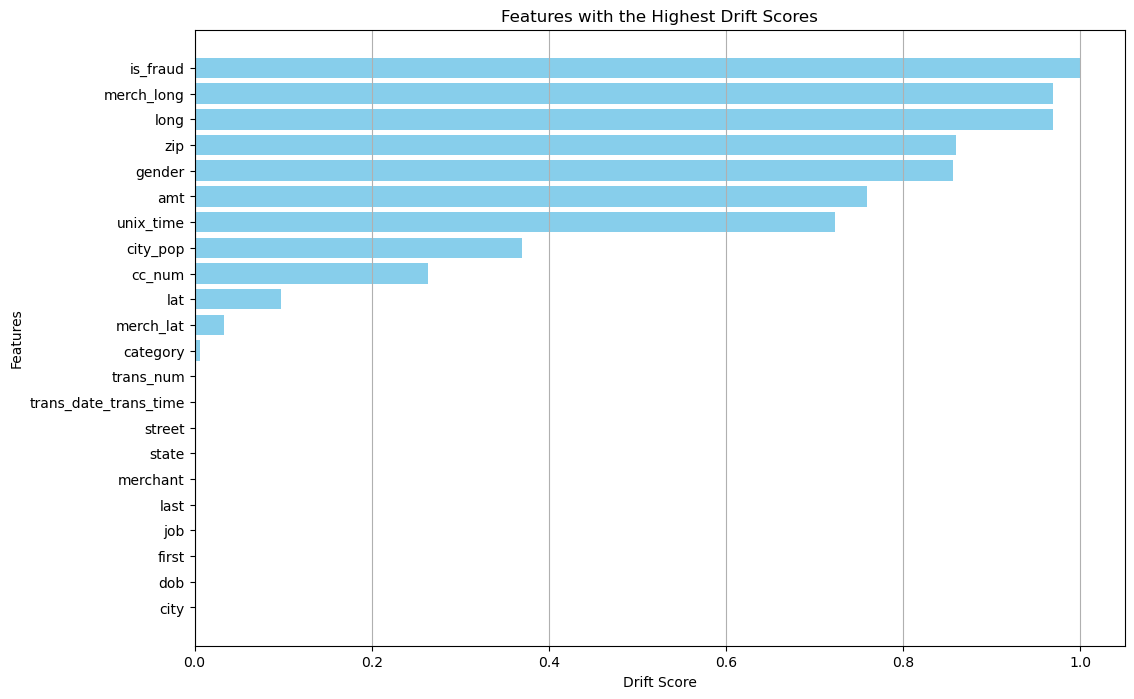

In [40]:
# Extraire les informations de drift
drift_data = data_drift_dict['metrics'][1]['result']['drift_by_columns']

# Trier les colonnes par drift_score (en ordre décroissant)
sorted_drift_data = sorted(drift_data.items(), key=lambda x: x[1]['drift_score'])

# Obtenir les noms des colonnes et leurs scores de drift
columns = [item[0] for item in sorted_drift_data]
drift_scores = [item[1]['drift_score'] for item in sorted_drift_data]

# Afficher les résultats
plt.figure(figsize=(12, 8))
plt.barh(columns, drift_scores, color='skyblue')
plt.xlabel('Drift Score')
plt.ylabel('Features')
plt.title('Features with the Highest Drift Scores')
plt.grid(axis='x')
plt.show()